<a href="https://colab.research.google.com/github/themathedges/3YP-Standalone-Kennington/blob/main/Ravi/Sandford_Generation_Bar_Chart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sandford Monthly Generation Bar Chart Data

Author: Ravi Kohli

Date: November 18th, 2020

College: Christ Church

**Goal:** Convert the monthly data provided by David into a saved data format so we can investigate relationships between the power generation and other variables, including:
- precipitation
- river levels
- temperature

In [1]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import pickle
from matplotlib.dates import DateFormatter
from scipy.stats import pearsonr
from scipy import signal

In [3]:
# start typing in the genenration values for a monthly basis
monthly_sandford_generation = np.array([181051, 190126, 204585, 207951, 154112, 49882, 75884, 11172, 22088, 18483, 96626]) # data is in kWh

In [4]:
# creating the dates array from December 2018 to October 2019 inclusive
months = [datetime.date(2018, 12, 1)] + [datetime.date(2019, s, 1) for s in range(1, 11)] 
months_dt = pd.to_datetime(months)

## Comparison with Precipitation Level Data

In [5]:
# unpickle the precipitation monthly/ annual dataframe
path = '/content/drive/My Drive/3YP/data/'
filename = 'precipitation_data_processed'
infile = open(path+filename, 'rb')
precipitation_monthly_df = pickle.load(infile)
infile.close()

In [6]:
precip_overlay_part1 = precipitation_monthly_df.iloc[250][12:13] # getting the December 2018 data
precip_overlay_part2 = precipitation_monthly_df.iloc[251][1:11]  # getting the 2019 data
precip_df = pd.concat([precip_overlay_part1, precip_overlay_part2])
precip_df

Dec     76.1
Jan     58.6
Feb     24.1
Mar     83.4
Apr     52.8
May     86.2
June     2.5
July    23.2
Aug     43.2
Sept    30.3
Oct     50.1
dtype: object

We are now going to plot the Sandford Hydro generation data and overlay the precipitation data on top of it

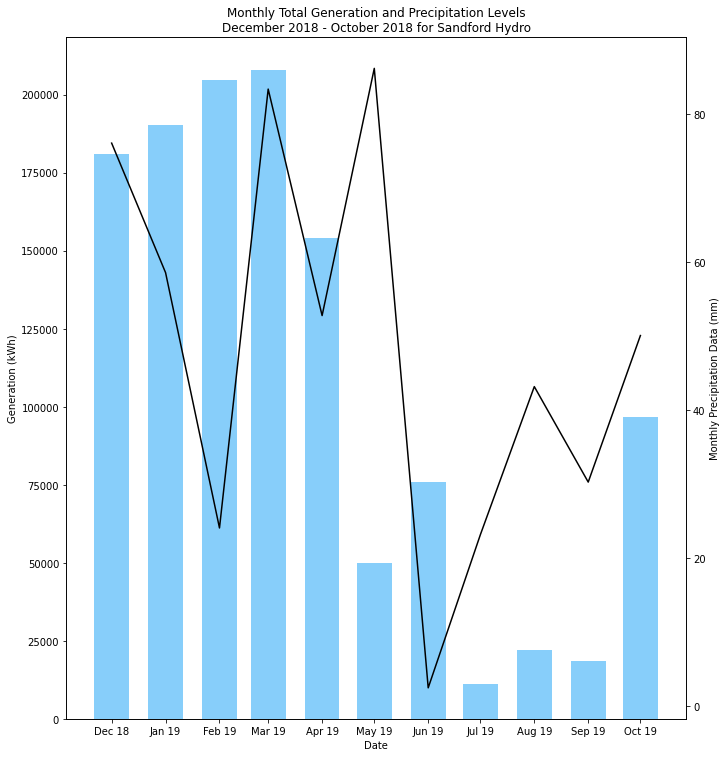

In [7]:
months_fig, months_ax = plt.subplots(figsize=(10, 10))

months_ax2 = months_ax.twinx()  # instantiate a second axes that shares the same x-axis

# Add x-axis and y-axis to the bar chart
# Overlaying the precipitation data on top of the hydro generation data
months_ax.bar(months_dt, monthly_sandford_generation, color='lightskyblue', width = 20)   
months_ax2.plot(months_dt, precip_df.values, color='k')                 
months_ax2.set_ylabel('Monthly Precipitation Data (mm)')                # we already handled the x-label with ax1

months_fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Set title and labels for axes
months_ax.set(xlabel="Date", ylabel="Generation (kWh)", title="Monthly Total Generation and Precipitation Levels\nDecember 2018 - October 2019 for Sandford Hydro")

# Change the date format if we want
date_form = DateFormatter('%b %y') #DateFormatter("%m-%d")
months_ax.xaxis.set_major_formatter(date_form)

plt.show()

**Note to self:** refer to https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/ for how to edit the date formatting on the axis

**Results from the Graph:** 

### Correlation Calculations of the Generation Data with Precipitation Levels

**Hypothesis**: Is there a correlation between the precipitation levels and the generation data?

In [8]:
# calculate Pearson's correlation between the generation data and the precipitation levels
corr, _ = pearsonr(monthly_sandford_generation, precip_df.values)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.375


We are using $ n = 11 $ data points, and thus the hypothesis test will have $ n - 2 $ degrees of freedom

Looking at a table for 2-tailed hypothesis tests for correlation coefficients, we can see that this value is not greater than any of the test statistics at the following levels[1]:
- 10%: 0.521
- 5%: 0.602
- 1%: 0.735

and therefore we cannot conclude that there is a significant correlation for a lag of 0

### Autocorrelation

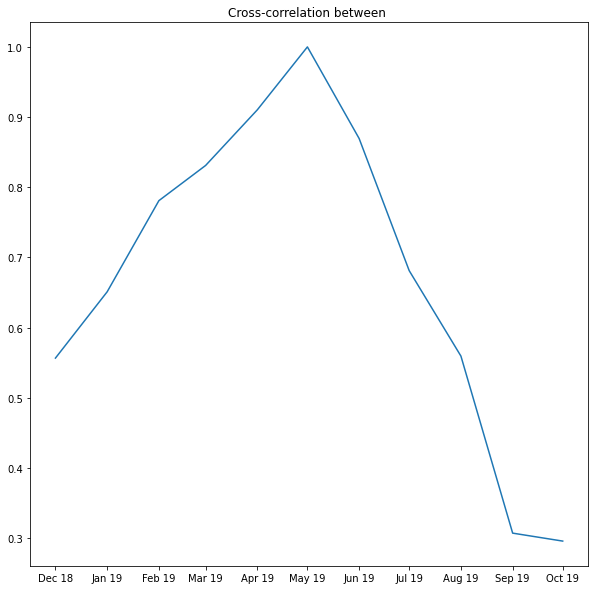

In [9]:
corr = signal.correlate(monthly_sandford_generation, precip_df.values, mode = 'same')   #, mode='same')
fig_corr1, ax_corr1 = plt.subplots(figsize=(10, 10))   
ax_corr1.plot(months_dt, corr / max(corr))
ax_corr1.set_title('Cross-correlation between ')
# Change the date format if we want
date_form = DateFormatter('%b %y') #DateFormatter("%m-%d")
ax_corr1.xaxis.set_major_formatter(date_form)

In [10]:
corr

array([36980448.20000001, 43255131.1, 51882713.900000006, 55213153.3,
       60481390.29999999, 66434018.1, 57763404.9, 45257075.5,
       37168714.00000001, 20412603.599999998, 19659270.6], dtype=object)

## Comparison with River Level Data

In [11]:
# unpickle the river level dataframe
path = '/content/drive/My Drive/3YP/data/'
filename = 'independent_river_level_data_processed'
infile = open(path+filename, 'rb')
river_level_df = pickle.load(infile)
infile.close()

In [12]:
# now we need to extract data from the required date ranges
start_date = '2018-12-1'
end_date = '2019-11-30'

#greater than the start date and smaller than the end date
mask = (river_level_df['date'] >= start_date) & (river_level_df['date'] <= end_date)

river_date_range_df = river_level_df.loc[mask]

In [13]:
# group the rows to get the monthly sum so we can plot that
river_date_range_df = river_date_range_df.groupby(pd.Grouper(key="date", freq='1m')).mean()

In [14]:
river_date_range_df.avg_level.values[:12]     # just extracting the data for December through to October

array([0.08958065, 0.07429032, 0.06778571, 0.08229032, 0.08103333,
       0.08954839, 0.09293333, 0.08267742, 0.07058065, 0.0601    ,
       0.10170968, 0.07086667])

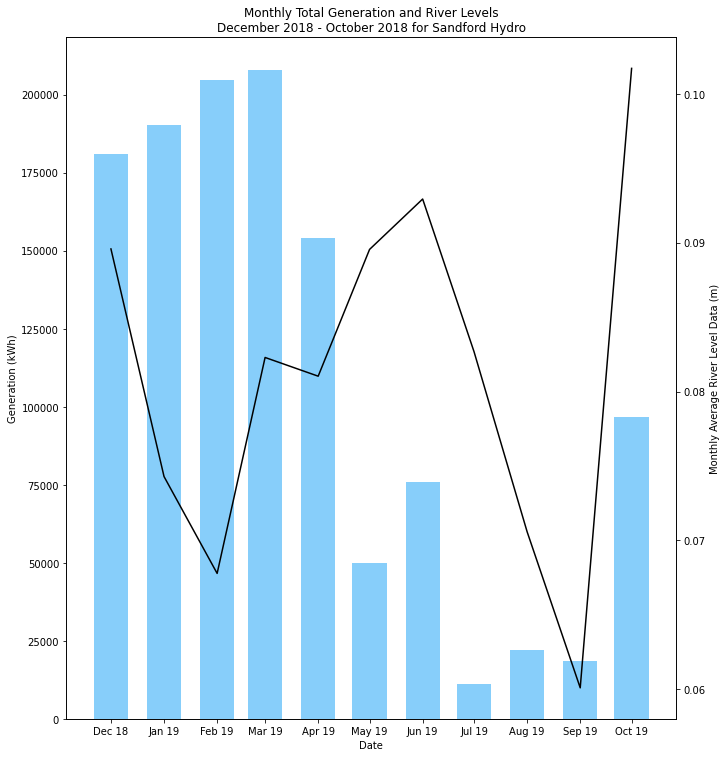

In [16]:
river_precip_fig, river_precip_ax = plt.subplots(figsize=(10, 10))

river_precip_ax2 = river_precip_ax.twinx()  # instantiate a second axes that shares the same x-axis

# Add x-axis and y-axis to the bar chart
# Overlaying the river level data on top of the hydro generation data
river_precip_ax.bar(months_dt, monthly_sandford_generation, color='lightskyblue', width = 20)   
river_precip_ax2.plot(months_dt, river_date_range_df.avg_level.values[:11], color='k')                 
river_precip_ax2.set_ylabel('Monthly Average River Level Data (m)')                # we already handled the x-label with ax1

river_precip_fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Set title and labels for axes
river_precip_ax.set(xlabel="Date", ylabel="Generation (kWh)", title="Monthly Total Generation and River Levels\nDecember 2018 - October 2019 for Sandford Hydro")

# Change the date format if we want
date_form = DateFormatter('%b %y') #DateFormatter("%m-%d")
river_precip_ax.xaxis.set_major_formatter(date_form)

plt.show()

### Correlation Coefficient calculation


In [17]:
# calculate Pearson's correlation between the generation data and the precipitation levels
corr2, _ = pearsonr(monthly_sandford_generation, river_date_range_df.avg_level.values[:11])
print('Pearsons correlation: %.3f' % corr2)

Pearsons correlation: 0.043


# References

- https://www.statisticssolutions.com/table-of-critical-values-pearson-correlation/